# Porosity prediction model

## Contents

* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Model training](#Model-training)
* [Inference](#Inference)
* [Metrics evaluation](#Metrics-evaluation)
    * [Model performance evaluation](#Model-performance-evaluation)
    * [Petrophysicist performance evaluation](#Petrophysicist-performance-evaluation)
* [Conclusion](#Conclusion)

## Problem description

Predict formation porosity based on well logs data.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

sys.path.insert(0, os.path.join("..", "..", ".."))
from petroflow import WellDataset, WS
from petroflow.batchflow import Pipeline, B, V
from petroflow.batchflow.models.torch import UNet

In [2]:
sns.set_style("ticks")

## Dataset

A datased of 50 wells with performed core-to-log matching is used to predict porosity:

In [3]:
MATCHED_DATASET_PATH = "/Matched_dataset/*"
matched_ds = WellDataset(path=MATCHED_DATASET_PATH, dirs=True, sort=True)

Only boring sequences, matched with $R^2 > 0.6$ and using modes, given below are kept in the dataset:

In [4]:
MATCHING_MODES = [
    "GK ~ core_logs.GK",
    "DENSITY ~ core_logs.DENSITY",
    "DENSITY ~ core_properties.DENSITY",
    "DENSITY ~ core_properties.POROSITY",
    "DT ~ core_properties.POROSITY",
    "NKTD ~ core_properties.POROSITY",
]

MATCHING_R2_THR = 0.6

Porosity is predicted by DENSITY, DT, NKTD, SP and GK logs. Additionally, depth information will be passed to the model.

In [5]:
LOG_MNEMONICS = ["DENSITY", "DT", "NKTD", "SP", "GK"]

Well logs and core properties dataframes will be resampled to a sampling rate of 1 cm in order to cast them to the same length.

In [6]:
REINDEXATION_STEP = 0.01

The model is trained on crops of length 1.28 m:

In [7]:
CROP_LENGTH = 128
CROP_LENGTH_M = CROP_LENGTH * REINDEXATION_STEP

Dataset filterring:

In [8]:
template_filtering_pipeline = (Pipeline()
    .keep_logs(LOG_MNEMONICS + ["KPO"])
    .keep_matched_sequences(mode=MATCHING_MODES, threshold=MATCHING_R2_THR)
    .drop_nans()
    .drop_short_segments(CROP_LENGTH_M)
    .add_depth_log()
    .reindex(step=REINDEXATION_STEP, attrs=["logs", "core_properties"])
    .interpolate(attrs="logs", limit_direction="both")
)

filtering_pipeline = matched_ds >> template_filtering_pipeline
filtered_batch = filtering_pipeline.next_batch(len(matched_ds))

In [9]:
n_wells = len(filtered_batch.wells)
n_segments = sum(well.n_segments for well in filtered_batch.wells)

print("The number of wells in the filtered dataset:", n_wells)
print("The number of boring sequences in the filtered dataset:", n_segments)

The number of wells in the filtered dataset: 15
The number of boring sequences in the filtered dataset: 63


Filtered dataset creation:

In [10]:
def build_dataset(batch):
    preloaded = ({k: v for k, v in zip(batch.indices, batch.wells)},)
    ds = WellDataset(index=batch.index, preloaded=preloaded)
    return ds

In [11]:
filtered_ds = build_dataset(filtered_batch)
filtered_ds.split(0.8, shuffle=123)

Filtered dataset is split into training and testing subsets with an 80:20 ratio.

In [12]:
train_wells = ", ".join(filtered_ds.train.indices)
print("Wells used for model training:", train_wells)

test_wells = ", ".join(filtered_ds.test.indices)
print("Wells used for model testing:", test_wells)

Wells used for model training: 126р, 416по, 507по, 504по, 601по, 318по, 215по, 492по, 611р, 2207ст2, 612р, 615по
Wells used for model testing: 501по, 509по, 415по


Log quantiles (0.01 and 0.99) are calculated for further normalization:

In [13]:
train_batch = (filtered_ds.train
    .next_batch(len(filtered_ds.train), shuffle=False, drop_last=False)
    .keep_logs(LOG_MNEMONICS + ["DEPTH"])
)

train_logs = pd.concat([seg.logs for well in train_batch.wells for seg in well.iter_level()])
q1 = train_logs.quantile(0.01)
q99 = train_logs.quantile(0.99)

## Model architecture

UNet model is used to predict formation porosity (https://analysiscenter.github.io/batchflow/api/batchflow.models.torch.unet.html).

However, instead of predicting porosity itself, the model predicts parameters of the beta distribution over porosity. This is done in order to get model’s confidence in its prediction.

Model configuration:
* input shape - [6, 128] (5 types of logs and depth)
* output shape - [2, 128] - 2 parameters of beta distribution for each sample in the crop
* the number of filters in encoder and corresponding decoder blocks - [16, 16, 32, 32]
* each encoder and decoder block has "cna cna" layout with a kernel size of 3 and a ReLU activation
* downsampling in the encoder is performed by a max pooling operation with a kernel size and a stride of 2
* upsampling in the decoder is performed by a transposed convolution with a kernel size of 4 and a stride of 2, followed by batch normalization and a ReLU activation.

Adam optimizer with default parameters is used for model training. Negative log-likelihood of the beta distribution is used as a loss function.

Model configuration specification:

In [14]:
class BetaNLLLoss(nn.Module):
    def forward(self, pred, true):
        not_nan_mask = ~torch.isnan(true)
        true = true[not_nan_mask]
        alpha = pred[:, :1, :][not_nan_mask]
        beta = pred[:, 1:, :][not_nan_mask]
        loss = torch.mean(torch.lgamma(alpha) + torch.lgamma(beta) - torch.lgamma(alpha + beta) -
                          (alpha - 1) * torch.log(true) - (beta - 1) * torch.log(1 - true))
        return loss

def porosity(pred):
    return (pred[:, 0, :] / pred.sum(dim=1)) * 100

model_config = {
    "initial_block/inputs": "x",
    "head/num_classes": 2,
    "inputs": dict(x={"shape": (len(LOG_MNEMONICS) + 1, CROP_LENGTH)}, 
                   y={"name": "targets", "shape": (2, CROP_LENGTH)}),
    "body/filters": [16, 16, 32, 32],
    "body/encoder": dict(layout="cnacna", kernel_size=3),
    "body/decoder": dict(layout="cnacna", kernel_size=3),
    "body/upsample": dict(layout="tna", kernel_size=4, strides=2),
    "head": dict(layout="cnaca", kernel_size=3, conv=dict(bias=True), activation=["relu", "softplus"]),
    "loss": BetaNLLLoss,
    "output": porosity,
    "optimizer": "Adam",
}

## Model training

The model is trained for 3000 epochs with a batch size of 4.

In [15]:
N_EPOCHS = 3000
BATCH_SIZE = 4

8 crops are sampled from each well in a batch:

In [16]:
N_CROPS = 8

Training pipeline specification:

In [17]:
template_train_pipeline = (Pipeline()
    .add_namespace(np)
    .init_variable("loss", default=[])
    .init_model("dynamic", UNet, "UNet", model_config)
    .keep_logs(LOG_MNEMONICS + ["DEPTH"])
    .interpolate(attrs="core_properties", limit=10, limit_area="inside")
    .norm_min_max(q1, q99)
    .random_crop(CROP_LENGTH_M, N_CROPS)
    .update(B("logs"), WS("logs").ravel())
    .stack(B("logs"), save_to=B("logs"))
    .swapaxes(B("logs"), 1, 2, save_to=B("logs"))
    .array(B("logs"), dtype=np.float32, save_to=B("logs"))
    .update(B("mask"), WS("core_properties")["POROSITY"].ravel())
    .stack(B("mask"), save_to=B("mask"))
    .expand_dims(B("mask"), 1, save_to=B("mask"))
    .divide(B("mask"), 100, save_to=B("mask"))
    .array(B("mask"), dtype=np.float32, save_to=B("mask"))
    .train_model("UNet", B("logs"), B("mask"), fetches="loss", save_to=V("loss", mode="a"))
    .run(batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, shuffle=True, drop_last=True, bar=True, lazy=True)
)

train_pipeline = filtered_ds.train >> template_train_pipeline

Model training:

In [18]:
train_pipeline.run()

100%|██████████| 9000/9000 [58:48<00:00,  2.58it/s]  


Loss function against the number of epochs:

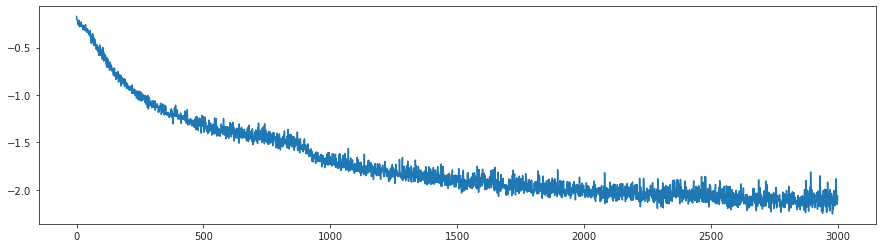

In [19]:
train_loss = [np.mean(l) for l in np.array_split(train_pipeline.v("loss"), N_EPOCHS)]

_ = plt.figure(figsize=(15, 4))
plt.plot(train_loss)
plt.show()

Training loss almost reaches a plateau by the end of the training, meaning that the learning process has converged.

## Inference

Inference pipeline is similar to a combination of filtering and training pipelines, except for 2 main differences:
* inference is performed at all depths along the wellbore, where all 5 logs are defined, so `keep_matched_sequences` action is removed
* `random_crop` method is changed to `crop`

In [21]:
template_predict_pipeline = (Pipeline()
    .add_namespace(np)
    .import_model("UNet", train_pipeline)
    .keep_logs(LOG_MNEMONICS)
    .drop_nans()
    .drop_short_segments(CROP_LENGTH_M)
    .add_depth_log()
    .reindex(step=REINDEXATION_STEP, attrs=["logs"])
    .interpolate(attrs="logs", limit_direction="both")
    .norm_min_max(q1, q99)
    .crop(CROP_LENGTH_M, CROP_LENGTH_M, drop_last=True)
    .update(B("logs"), WS("logs").ravel())
    .stack(B("logs"), save_to=B("logs"))
    .swapaxes(B("logs"), 1, 2, save_to=B("logs"))
    .array(B("logs"), dtype=np.float32, save_to=B("logs"))
    .predict_model("UNet", B("logs"), fetches="porosity", save_to=WS("logs")["KP"])
)

Porosity prediction for a new well, stored in `WELL_PATH`: 

In [22]:
WELL_PATH = "/Matched_dataset/415по/"
predict_ds = WellDataset(path=WELL_PATH, dirs=True)
well = (predict_ds >> template_predict_pipeline).next_batch(1).wells[0]

As a result, porosity prediction for each segment will be saved in `logs` attribute under KP mnemonic:

In [23]:
well.iter_level()[0].logs.head()

,DENSITY,DT,NKTD,SP,GK,DEPTH,KP
DEPTH,,,,,,,
2400.00,0.311604,0.741773,0.028643,0.388278,0.672840,0.537369,7.888700
2400.01,0.297554,0.743117,0.028614,0.388980,0.675854,0.537373,8.179901
2400.02,0.283504,0.744461,0.028586,0.389681,0.678869,0.537378,8.405969
2400.03,0.269454,0.745805,0.028557,0.390382,0.681883,0.537383,8.635429
2400.04,0.255404,0.747149,0.028529,0.391083,0.684898,0.537388,8.111633


## Metrics evaluation

Two metrics are used for model evaluation:
* Mean absolute error (MAE)
* Share of predictions, having an absolute error less than 2 absolute percent of porosity (ACC)

In [24]:
def calc_metrics(kpo_pred, kpo_true):
    abs_err = np.abs(kpo_true - kpo_pred)
    n_not_nan = np.sum(~np.isnan(abs_err))
    print("MAE:", np.nanmean(abs_err))
    print("ACC:", np.nansum(abs_err <= 2) / n_not_nan)
    plt.hist(abs_err, bins=30)
    plt.show()

### Model performance evaluation

Model evaluation pipeline:

In [25]:
template_model_test_pipeline = (Pipeline()
    .add_namespace(np)
    .init_variable("true", default=[])
    .init_variable("pred", default=[])
    .import_model("UNet", train_pipeline)
    .keep_logs(LOG_MNEMONICS + ["DEPTH"])
    .norm_min_max(q1, q99)
    .crop(CROP_LENGTH_M, CROP_LENGTH_M, drop_last=True)
    .update(B("logs"), WS("logs").ravel())
    .stack(B("logs"), save_to=B("logs"))
    .swapaxes(B("logs"), 1, 2, save_to=B("logs"))
    .array(B("logs"), dtype=np.float32, save_to=B("logs"))
    .predict_model("UNet", B("logs"), fetches="porosity", save_to=V("pred", mode="a"))
    .update(V("true", mode="e"), WS("core_properties")["POROSITY"].ravel())
    .run(batch_size=1, n_epochs=1, shuffle=False, drop_last=False, lazy=True)
)

Metrics evaluation:

In [26]:
model_test_pipeline = (filtered_ds.test >> template_model_test_pipeline).run()

MAE: 2.81137160978905
ACC: 0.47413793103448276


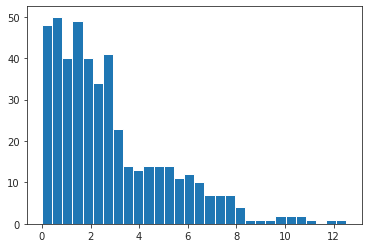

In [27]:
true = pd.concat(model_test_pipeline.v("true"))
pred = np.concatenate(model_test_pipeline.v("pred")).ravel()
calc_metrics(pred, true)

### Petrophysicist performance evaluation

The same metrics can be used to evaluate performance of petrophysicists using KPO log:

In [28]:
template_human_test_pipeline = (Pipeline()
    .init_variable("true", default=[])
    .init_variable("pred", default=[])
    .keep_logs("KPO")
    .update(V("true", mode="e"), WS("core_properties")["POROSITY"].ravel())
    .update(V("pred", mode="e"), WS("logs")["KPO"].ravel())
    .run(batch_size=1, n_epochs=1, shuffle=False, drop_last=False, lazy=True)
)

human_test_pipeline = (filtered_ds.test >> template_human_test_pipeline).run()

MAE: 3.8762009407289617
ACC: 0.3298538622129436


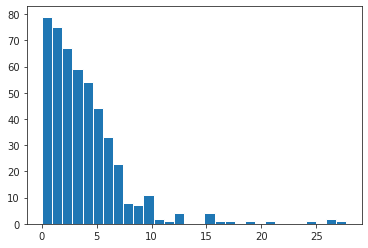

In [29]:
true = pd.concat(human_test_pipeline.v("true"))
pred = pd.concat(human_test_pipeline.v("pred"))
calc_metrics(pred, true)

## Conclusion

A model for porosity prediction was trained on DENSITY, DT, NKTD, SP and GK logs from 12 wells. The model was tested on 3 wells, its mean absolute error is 2.81 absolute porosity percent, which is better than petrophysicists' performance by more than 1 absolute percent.